# Cell Types Project Master Notebook

In [1]:
#Import the "Cell Types Cache" from the AllenSDK core package
from allensdk.core.cell_types_cache import CellTypesCache

#Import CellTypesApi, which will allow us to query the database.
from allensdk.api.queries.cell_types_api import CellTypesApi

# initialize cache as 'ctc' (cell types cache)
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# import tool used to get AP spike data for specimen
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

# get rid of all the ugly red warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

The paper used mouse data, so filter the cells data to get only mouse specimen.

In [2]:
mouse_cells_df = pd.DataFrame(ctc.get_cells(species = ['mus musculus']))
mouse_ids_df = mouse_cells_df[['id','dendrite_type']].set_index('id')
print('num specimen: ' + str(mouse_ids_df.shape[0]))
mouse_ids_df.head()

num specimen: 1920


,dendrite_type
id,
565871768,aspiny
469801138,aspiny
605889373,aspiny
485909730,spiny
323865917,spiny


Get the ids of all specimen with electrophysiology features. Include the rheobase sweep number for later.

In [3]:
ephys_features_df = pd.DataFrame(ctc.get_ephys_features())
ephys_ids_df = ephys_features_df[['specimen_id','rheobase_sweep_number']].set_index('specimen_id')
print('num specimen: ' + str(ephys_ids_df.shape[0]))
ephys_ids_df.head()

num specimen: 2333


,rheobase_sweep_number
specimen_id,
529878215,78
548459652,55
579978640,38
439024551,41
515188639,36


Use inner join to get specimen ids of mice that have ephys data.

Assuming 'id' in mouse cells df the same as 'specimen id' in ephys data, we can get the rheobase sweep number for each mouse specimen.

In [4]:
me_rheobase_df = mouse_ids_df.join(ephys_ids_df).reset_index()

# renaming the column here makes it easier to merge/join dataframes later
me_rheobase_df = me_rheobase_df.rename(columns={"id": "specimen_id"})

# this df has mouse ephys rheobase data
print('num specimen: ' + str(me_rheobase_df.shape[0]))
me_rheobase_df.head()

num specimen: 1920


,specimen_id,dendrite_type,rheobase_sweep_number
0,565871768,aspiny,40
1,469801138,aspiny,57
2,605889373,aspiny,53
3,485909730,spiny,33
4,323865917,spiny,34


Get the morphology dataset.

In [5]:
morph_feats_df = pd.DataFrame(ctc.get_morphology_features())
print('num specimen: ' + str(morph_feats_df.shape[0]))

num specimen: 671


Now we use the morphology dataset to select for specimen that are mice, have ephys data, and have morphology data by performing an inner merge of the two datasets. Get the ids from this merged dataset and make a morphology dataframe of those ids in addition to an electrophysiology dataframe.

In [6]:
ephys_morph_mice_df = me_rheobase_df.merge(morph_feats_df,on='specimen_id', how='inner')

# this contains the ids of the mice with ephys and morph data
df_ids = ephys_morph_mice_df[['specimen_id']]

# make ephys df of only the mice with morphology and ephys data
ephys_df = ephys_features_df.merge(df_ids, on='specimen_id', how='inner')

# make morphology df of only the mice with morphology and ephys data
morph_df = morph_feats_df.merge(df_ids, on='specimen_id', how='inner')

We created a helper method to classify each specimen as inhibitory or excitatory by accessing their dendrite type in the `.get_cells()` method.

In [7]:
def classify(specimen_id):
    '''classifies a specimen as inhibitory or excitatory based on if its spiny or aspiny'''
    a_or_s = mouse_ids_df.loc[specimen_id]['dendrite_type']
    
    if a_or_s == 'spiny':
        return 'excitatory'
    else:
        return 'inhibitory'

Next we added a column to specify inhibitory or excitatory type to the electrophysiology and morphology data.

In [8]:
ephys_df['inhib/excit'] = ephys_df['specimen_id'].apply(classify)
ephys_df.head()

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,inhib/excit
0,0.044825,91.322222,-46.761876,0.223864,1.190240,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,1.806510,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374,excitatory
1,0.002303,8.756140,-33.787497,0.636671,1.729100,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,1.298640,-61.031254,-65.000005,-79.625003,0.987204,1.191762,1.294996,-85.593750,-79.520042,inhibitory
2,0.008008,42.867391,-111.638115,0.325524,1.101295,1.775697,1.025883,-67.406250,-66.593753,-67.802085,...,1.054124,-67.656250,-66.791669,-68.546875,2.350017,2.142121,2.262525,-100.187500,-66.241074,inhibitory
3,0.011140,44.374545,-28.642500,0.286192,1.060140,2.981870,1.025220,-47.531250,-48.437502,-51.054690,...,1.631545,-47.593754,-48.562502,-69.421877,3.782685,3.628545,4.015633,-99.187508,-68.897186,inhibitory
4,0.059450,238.470000,-11.630000,0.151066,1.095720,8.038240,1.025250,-49.406254,-48.479170,-57.390629,...,1.188280,-50.968750,-51.562501,-78.906254,2.320162,2.316604,2.936915,-95.500008,-83.018768,excitatory


In [9]:
morph_df['inhib/excit'] = morph_df['specimen_id'].apply(classify)
morph_df = morph_df.set_index('specimen_id')
print('num specimen: ' + str(morph_df.shape[0]))
morph_df.head()

num specimen: 519


,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id,max_branch_order,max_euclidean_distance,...,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume,inhib/excit
specimen_id,,,,,,,,,,,,,,,,,,,,,
478107198,82.727781,NaN,0.864267,0.345092,20.723077,0.964510,NaN,491119743,6.0,99.779724,...,0.1144,0.1144,0.28,435.740270,False,3D Neuron Reconstruction morphology,1666.082926,1803.875644,167.343086,inhibitory
502367941,82.506680,NaN,0.903890,0.634047,105.277778,0.862183,NaN,546781359,3.0,432.383110,...,0.1144,0.1144,0.28,1446.587725,False,3D Neuron Reconstruction morphology,2277.259374,4543.139073,921.571895,excitatory
515771244,77.536678,NaN,0.863104,0.417929,73.666667,0.926633,NaN,537042261,6.0,373.630444,...,0.1144,0.1144,0.28,287.118123,False,3D Neuron Reconstruction morphology,3589.339062,4704.910407,582.285423,excitatory
591268268,72.019250,NaN,0.873518,0.227626,47.535714,1.000000,NaN,657879305,5.0,186.218009,...,0.1144,0.1144,0.28,55.055236,False,3D Neuron Reconstruction morphology,1659.465869,1185.773462,69.144146,inhibitory
469753383,68.459909,NaN,0.889767,0.259649,28.263158,1.085194,NaN,491120305,6.0,107.897533,...,0.1144,0.1144,0.28,358.755159,False,3D Neuron Reconstruction morphology,1825.646321,1499.858295,108.114604,inhibitory


Get rid of columns that are not quantitative, aside from the inhibitory/excitatory column.

In [10]:
# also drop columns that arent quantitative, aside from the inhib/excit columns
morph_df = morph_df.drop(columns=['superseded','tags','neuron_reconstruction_type'])

In [11]:
# check for null values
morph_df.isnull().sum()

average_bifurcation_angle_local       0
average_bifurcation_angle_remote    519
average_contraction                   0
average_diameter                      0
average_fragmentation                 0
average_parent_daughter_ratio         0
hausdorff_dimension                 519
id                                    0
max_branch_order                      0
max_euclidean_distance                0
max_path_distance                     0
number_bifurcations                   0
number_branches                       0
number_nodes                          0
number_stems                          0
number_tips                           0
overall_depth                         0
overall_height                        0
overall_width                         0
scale_factor_x                        0
scale_factor_y                        0
scale_factor_z                        0
soma_surface                          0
total_length                          0
total_surface                         0


`morph_df` has nan for all of its values in 'hausdorff_dimension' and 'average_bifurcation_angle_remote', so get rid of those columns.

In [12]:
# dont include columns in morph_df unrelated to morphology (ie. id numbers)
morph_columns = list(morph_df.columns)
morph_columns.remove('id')
morph_columns.remove('average_bifurcation_angle_remote')
morph_columns.remove('hausdorff_dimension')
morph_columns.remove('inhib/excit')
morph_columns


['average_bifurcation_angle_local',
 'average_contraction',
 'average_diameter',
 'average_fragmentation',
 'average_parent_daughter_ratio',
 'max_branch_order',
 'max_euclidean_distance',
 'max_path_distance',
 'number_bifurcations',
 'number_branches',
 'number_nodes',
 'number_stems',
 'number_tips',
 'overall_depth',
 'overall_height',
 'overall_width',
 'scale_factor_x',
 'scale_factor_y',
 'scale_factor_z',
 'soma_surface',
 'total_length',
 'total_surface',
 'total_volume']

In [13]:
inhib_morph_df = morph_df[morph_df['inhib/excit'] == 'inhibitory'].drop(columns = ['inhib/excit'])
excit_morph_df = morph_df[morph_df['inhib/excit'] == 'excitatory'].drop(columns = ['inhib/excit'])
print("inhib df shape:" + str(inhib_morph_df.shape))
print("excit df shape:" + str(excit_morph_df.shape))

inhib df shape:(279, 26)
excit df shape:(240, 26)


### AP Half Width Calculation

We can calculate AP half width by accessing a speciman's rheobase sweep data through it's rheobase sweep number.

In [14]:
# setting index here allows us to use .loc method in helper function
rheobase_df = me_rheobase_df.set_index('specimen_id')
rheobase_df

,dendrite_type,rheobase_sweep_number
specimen_id,,
565871768,aspiny,40
469801138,aspiny,57
605889373,aspiny,53
485909730,spiny,33
323865917,spiny,34
...,...,...
512322162,spiny,44
488473535,aspiny,57
467003163,spiny,45


Use a helper function to calculate spike width.

In [15]:
def calc_spike_width(specimen_id):
    ''' calculates the spike width using specimen id to get the data. returns 0.0 if file does not exist'''
    try:
        data_set = ctc.get_ephys_data(specimen_id)
        sweep_number = rheobase_df.loc[specimen_id]['rheobase_sweep_number']
        sweep_data = data_set.get_sweep(sweep_number)

        index_range = sweep_data["index_range"]
        i = sweep_data["stimulus"][0:index_range[1]+1] # in A
        v = sweep_data["response"][0:index_range[1]+1] # in V
        i *= 1e12 # to pA
        v *= 1e3 # to mV

        sampling_rate = sweep_data["sampling_rate"] # in Hz
        t = np.arange(0, len(v)) * (1.0 / sampling_rate)

        sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
        sweep_ext.process_spikes()

        return round(1e3 * np.nanmean(sweep_ext.spike_feature("width")),4)
    
    except OSError as e:
        return -100

Calculating the AP half width for the whole dataframe at this point takes an excessively long time due to the method since some of the iterations requires their own download. For this reason, we take a sample of the first 15 specimen and calculate their spike widths (AP half widths).

In [16]:
ephys40 = ephys_df.head(15)

In [17]:
ephys40['spike_width'] = ephys40['specimen_id'].apply(calc_spike_width)
ephys40

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,inhib/excit,spike_width
0,0.044825,91.322222,-46.761876,0.223864,1.190240,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374,excitatory,0.9183
1,0.002303,8.756140,-33.787497,0.636671,1.729100,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,-61.031254,-65.000005,-79.625003,0.987204,1.191762,1.294996,-85.593750,-79.520042,inhibitory,0.3753
2,0.008008,42.867391,-111.638115,0.325524,1.101295,1.775697,1.025883,-67.406250,-66.593753,-67.802085,...,-67.656250,-66.791669,-68.546875,2.350017,2.142121,2.262525,-100.187500,-66.241074,inhibitory,1.0400
3,0.011140,44.374545,-28.642500,0.286192,1.060140,2.981870,1.025220,-47.531250,-48.437502,-51.054690,...,-47.593754,-48.562502,-69.421877,3.782685,3.628545,4.015633,-99.187508,-68.897186,inhibitory,0.9100
4,0.059450,238.470000,-11.630000,0.151066,1.095720,8.038240,1.025250,-49.406254,-48.479170,-57.390629,...,-50.968750,-51.562501,-78.906254,2.320162,2.316604,2.936915,-95.500008,-83.018768,excitatory,0.8800
5,NaN,58.600000,-36.739996,0.095076,1.101680,11.133833,1.025875,-48.125004,-47.135418,-56.742191,...,-48.312504,-49.520835,-80.875006,2.121035,1.797871,2.397005,-93.906250,-80.402931,excitatory,0.9800
6,0.410374,24.886667,2.337500,0.053163,1.199040,11.020927,1.024433,-54.593754,-50.635418,-56.750004,...,-57.187500,-50.791668,-70.156255,1.783955,1.581153,1.861108,-100.375008,-69.816109,inhibitory,0.4800
7,0.176194,12.770000,-29.125001,0.828687,1.045960,9.596560,1.024035,-52.281254,-48.031252,-57.105471,...,-52.468754,-48.828127,-76.550787,1.566557,1.510595,1.713518,-89.937500,-76.392235,inhibitory,0.4000
8,0.054985,26.074167,-13.989375,0.035491,1.090215,3.391177,1.024271,-45.906254,-42.875003,-52.750002,...,-46.593750,-46.000003,-67.244795,2.347381,2.069299,2.389602,-94.218750,-66.155899,inhibitory,0.4625
9,0.046079,97.000000,23.797500,0.124640,1.156475,6.003742,1.025527,-42.000004,-42.354168,-46.335939,...,-52.562500,-53.708337,-72.765629,3.119665,3.083533,3.068449,-85.968758,-72.388512,excitatory,0.8217


Since our helper method returned '-100' every time the file required to calculate spike width was not found, we drop the rows with -100.

In [18]:
ephys40 = ephys40[ephys40['spike_width'] != -100]
ephys40

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,inhib/excit,spike_width
0,0.044825,91.322222,-46.761876,0.223864,1.190240,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374,excitatory,0.9183
1,0.002303,8.756140,-33.787497,0.636671,1.729100,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,-61.031254,-65.000005,-79.625003,0.987204,1.191762,1.294996,-85.593750,-79.520042,inhibitory,0.3753
2,0.008008,42.867391,-111.638115,0.325524,1.101295,1.775697,1.025883,-67.406250,-66.593753,-67.802085,...,-67.656250,-66.791669,-68.546875,2.350017,2.142121,2.262525,-100.187500,-66.241074,inhibitory,1.0400
3,0.011140,44.374545,-28.642500,0.286192,1.060140,2.981870,1.025220,-47.531250,-48.437502,-51.054690,...,-47.593754,-48.562502,-69.421877,3.782685,3.628545,4.015633,-99.187508,-68.897186,inhibitory,0.9100
4,0.059450,238.470000,-11.630000,0.151066,1.095720,8.038240,1.025250,-49.406254,-48.479170,-57.390629,...,-50.968750,-51.562501,-78.906254,2.320162,2.316604,2.936915,-95.500008,-83.018768,excitatory,0.8800
5,NaN,58.600000,-36.739996,0.095076,1.101680,11.133833,1.025875,-48.125004,-47.135418,-56.742191,...,-48.312504,-49.520835,-80.875006,2.121035,1.797871,2.397005,-93.906250,-80.402931,excitatory,0.9800
6,0.410374,24.886667,2.337500,0.053163,1.199040,11.020927,1.024433,-54.593754,-50.635418,-56.750004,...,-57.187500,-50.791668,-70.156255,1.783955,1.581153,1.861108,-100.375008,-69.816109,inhibitory,0.4800
7,0.176194,12.770000,-29.125001,0.828687,1.045960,9.596560,1.024035,-52.281254,-48.031252,-57.105471,...,-52.468754,-48.828127,-76.550787,1.566557,1.510595,1.713518,-89.937500,-76.392235,inhibitory,0.4000
8,0.054985,26.074167,-13.989375,0.035491,1.090215,3.391177,1.024271,-45.906254,-42.875003,-52.750002,...,-46.593750,-46.000003,-67.244795,2.347381,2.069299,2.389602,-94.218750,-66.155899,inhibitory,0.4625
9,0.046079,97.000000,23.797500,0.124640,1.156475,6.003742,1.025527,-42.000004,-42.354168,-46.335939,...,-52.562500,-53.708337,-72.765629,3.119665,3.083533,3.068449,-85.968758,-72.388512,excitatory,0.8217


# Ephys

In [19]:
# check to make sure there's no columns with all NaN values (like we saw in the morphology data)
ephys40.isnull().sum().sort_values(ascending=False)

slow_trough_v_short_square                5
slow_trough_t_short_square                5
slow_trough_t_long_square                 4
slow_trough_v_long_square                 4
slow_trough_t_ramp                        3
slow_trough_v_ramp                        3
adaptation                                1
trough_v_short_square                     0
has_pause                                 0
rheobase_sweep_id                         0
peak_v_short_square                       0
peak_v_ramp                               0
peak_v_long_square                        0
peak_t_short_square                       0
peak_t_ramp                               0
peak_t_long_square                        0
latency                                   0
input_resistance_mohm                     0
id                                        0
has_delay                                 0
ri                                        0
has_burst                                 0
fast_trough_v_short_square      

Get rid of columns with id numbers, and get rid of other non-numeric columns.

In [20]:
# checks the type of value in each column
ephys40.dtypes

adaptation                                float64
avg_isi                                   float64
electrode_0_pa                            float64
f_i_curve_slope                           float64
fast_trough_t_long_square                 float64
fast_trough_t_ramp                        float64
fast_trough_t_short_square                float64
fast_trough_v_long_square                 float64
fast_trough_v_ramp                        float64
fast_trough_v_short_square                float64
has_burst                                    bool
has_delay                                    bool
has_pause                                    bool
id                                          int64
input_resistance_mohm                     float64
latency                                   float64
peak_t_long_square                        float64
peak_t_ramp                               float64
peak_t_short_square                       float64
peak_v_long_square                        float64


In [21]:
ephys_columns = list(ephys40.columns)

# get rid of all the features theat involve the stimulus since theyre not related to the intrinsic
#properties of the neuron
cleaned_columns = []

for word in ephys_columns:
    if 'square' in word:
        print(word)
    elif 'ramp' in word:
        print(word)
    else:
        cleaned_columns.append(word)


# list of columns to omit
invalids = ['has_burst','has_delay','has_pause','inhib/excit','id', 'rheobase_sweep_id','specimen_id',\
            'thumbnail_sweep_id']

for i in invalids:
    cleaned_columns.remove(i)
        
cleaned_columns

fast_trough_t_long_square
fast_trough_t_ramp
fast_trough_t_short_square
fast_trough_v_long_square
fast_trough_v_ramp
fast_trough_v_short_square
peak_t_long_square
peak_t_ramp
peak_t_short_square
peak_v_long_square
peak_v_ramp
peak_v_short_square
slow_trough_t_long_square
slow_trough_t_ramp
slow_trough_t_short_square
slow_trough_v_long_square
slow_trough_v_ramp
slow_trough_v_short_square
threshold_i_long_square
threshold_i_ramp
threshold_i_short_square
threshold_t_long_square
threshold_t_ramp
threshold_t_short_square
threshold_v_long_square
threshold_v_ramp
threshold_v_short_square
trough_t_long_square
trough_t_ramp
trough_t_short_square
trough_v_long_square
trough_v_ramp
trough_v_short_square
upstroke_downstroke_ratio_long_square
upstroke_downstroke_ratio_ramp
upstroke_downstroke_ratio_short_square


['adaptation',
 'avg_isi',
 'electrode_0_pa',
 'f_i_curve_slope',
 'input_resistance_mohm',
 'latency',
 'rheobase_sweep_number',
 'ri',
 'sag',
 'seal_gohm',
 'tau',
 'vm_for_sag',
 'vrest',
 'spike_width']

In [22]:
inhib_ephys_df = ephys40[ephys40['inhib/excit'] == 'inhibitory'].drop(columns = ['inhib/excit'])
excit_ephys_df = ephys40[ephys40['inhib/excit'] == 'excitatory'].drop(columns = ['inhib/excit'])

print("inhib df shape:" + str(inhib_ephys_df.shape))
print("excit df shape:" + str(excit_ephys_df.shape))

inhib df shape:(8, 57)
excit df shape:(6, 57)


### Electrophysiology

Since we subtract excitatory from inhibitory means, a positive zscore indicates that the excitatory mean value is higher than the inhibitory mean value.

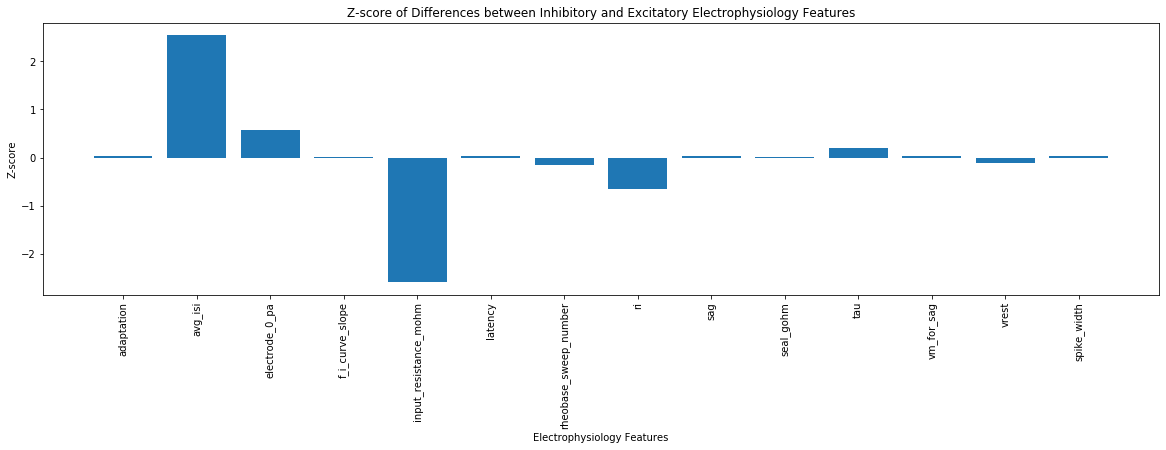

In [23]:
# Set up the figure
fig,ax = plt.subplots(figsize=(20,5))

differences = []

for i in cleaned_columns:
    inhib_mean = np.mean(inhib_ephys_df[i])
    excit_mean = np.mean(excit_ephys_df[i])
    differences.append(excit_mean - inhib_mean)

diff_zscore = stats.zscore(differences)
ax.bar(cleaned_columns, diff_zscore)
plt.xticks(rotation=90)

ax.set_xlabel('Electrophysiology Features')
ax.set_ylabel('Z-score')
ax.set_title("Z-score of Differences between Inhibitory and Excitatory Electrophysiology Features")

plt.show()

In [24]:
significant_indexes = []

for i in diff_zscore:
    if i >= 1.96:
        significant_indexes.append(i)
    elif i <= -1.96:
        significant_indexes.append(i)

# make a dictionary of columns and zscores
ephys_zscore_dict = dict()

for i in range(len(diff_zscore)):
    ephys_zscore_dict[cleaned_columns[i]] = [diff_zscore[i]]

ephys_zscores = pd.DataFrame(ephys_zscore_dict)
ephys_zscores = ephys_zscores[['avg_isi', 'input_resistance_mohm']]
ephys_zscores

,avg_isi,input_resistance_mohm
0,2.54098,-2.588591


After looking through the zscores, we see that 'avg_isi' and 'input_resistance_mohm' are the electrophysiology features that have  a zscore >= 1.96 or <= -1.96, indicating that there is a significant difference (with an alpha value of 0.05). The 'avg_isi' is positive, suggesting that the mean the average inter-spike-interval of excitatory neurons is significantly greater than that of the inhibitory neurons. Since input resistance mohm is negative, the mean of input resistance nohm of inhibitory neurons is significantly greater than that of the excitatory neurons.

### Morphology

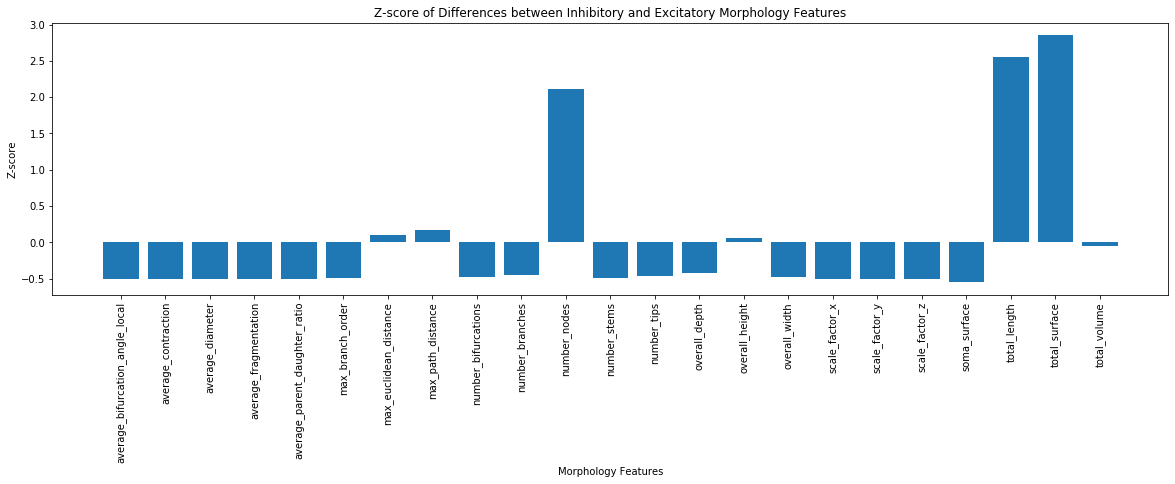

In [25]:
# Set up the figure
fig,ax = plt.subplots(figsize=(20,5))

differences = []

for i in morph_columns:
    inhib_mean = np.mean(inhib_morph_df[i])
    excit_mean = np.mean(excit_morph_df[i])
    differences.append(excit_mean - inhib_mean)

diff_zscore = stats.zscore(differences)
ax.bar(morph_columns, diff_zscore)
plt.xticks(rotation=90)

ax.set_xlabel('Morphology Features')
ax.set_ylabel('Z-score')
ax.set_title("Z-score of Differences between Inhibitory and Excitatory Morphology Features")

plt.show()

In [26]:
significant_indexes = []

for i in diff_zscore:
    if i >= 1.96:
        significant_indexes.append(i)
    elif i <= -1.96:
        significant_indexes.append(i)
        
# make a dictionary of columns and zscores
morph_zscore_dict = dict()

for i in range(len(diff_zscore)):
    morph_zscore_dict[morph_columns[i]] = [diff_zscore[i]]

morph_zscores = pd.DataFrame(morph_zscore_dict)
morph_zscores = morph_zscores[['number_nodes','total_length','total_surface']]
morph_zscores

,number_nodes,total_length,total_surface
0,2.113944,2.554072,2.852513


### Spike Width Comparison

Text(0.5, 1.0, 'AP Half Width in Inhibitory v Excitatory neurons')

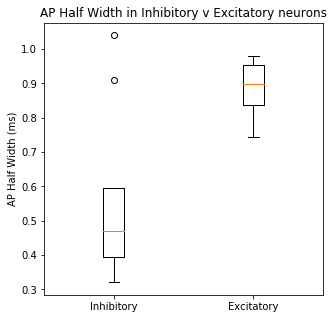

In [27]:
fig,ax = plt.subplots(figsize=(5,5))

inhib_spike_width = inhib_ephys_df['spike_width']
excit_spike_width = excit_ephys_df['spike_width']
data = [inhib_spike_width, excit_spike_width]

plt.boxplot(data)
ax.set_xticklabels(['Inhibitory', 'Excitatory'])
ax.set_ylabel('AP Half Width (ms)')
ax.set_title("AP Half Width in Inhibitory v Excitatory neurons")